<a href="https://colab.research.google.com/github/Nithi7518/Image-Encryption/blob/main/OpenMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Download stb header files needed for image loading/saving in C++
!wget -q https://raw.githubusercontent.com/nothings/stb/master/stb_image.h -O stb_image.h
!wget -q https://raw.githubusercontent.com/nothings/stb/master/stb_image_write.h -O stb_image_write.h
print("stb_image.h and stb_image_write.h downloaded.")

stb_image.h and stb_image_write.h downloaded.


In [10]:
%%writefile des_image_omp.cpp
#include <iostream>
#include <vector>
#include <cstdint>
#include <string>
#include <fstream>
#include <stdexcept>
#include <chrono>
#include <omp.h> // For OpenMP
#include <numeric> // For std::iota
#include <algorithm> // For std::reverse, std::copy
#include <random>    // For key generation
#include <iomanip> // For std::hex, std::setw, std::setfill

// --- STB Image Implementation ---
// Define these before including stb_image.h and stb_image_write.h in *one* C++ file
#define STB_IMAGE_IMPLEMENTATION
#include "stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image_write.h"
// --- End STB Image Implementation ---

const size_t DES_BLOCK_SIZE = 8; // Bytes

// --- DES Constants ---
// Initial Permutation (IP)
const uint8_t IP[] = {
    58, 50, 42, 34, 26, 18, 10, 2, 60, 52, 44, 36, 28, 20, 12, 4,
    62, 54, 46, 38, 30, 22, 14, 6, 64, 56, 48, 40, 32, 24, 16, 8,
    57, 49, 41, 33, 25, 17, 9, 1, 59, 51, 43, 35, 27, 19, 11, 3,
    61, 53, 45, 37, 29, 21, 13, 5, 63, 55, 47, 39, 31, 23, 15, 7};

// Final Permutation (IP^-1)
const uint8_t FP[] = {
    40, 8, 48, 16, 56, 24, 64, 32, 39, 7, 47, 15, 55, 23, 63, 31,
    38, 6, 46, 14, 54, 22, 62, 30, 37, 5, 45, 13, 53, 21, 61, 29,
    36, 4, 44, 12, 52, 20, 60, 28, 35, 3, 43, 11, 51, 19, 59, 27,
    34, 2, 42, 10, 50, 18, 58, 26, 33, 1, 41, 9, 49, 17, 57, 25};

// Permuted Choice 1 (PC-1) - For Key Schedule
const uint8_t PC1[] = {
    57, 49, 41, 33, 25, 17, 9, 1, 58, 50, 42, 34, 26, 18,
    10, 2, 59, 51, 43, 35, 27, 19, 11, 3, 60, 52, 44, 36,
    63, 55, 47, 39, 31, 23, 15, 7, 62, 54, 46, 38, 30, 22,
    14, 6, 61, 53, 45, 37, 29, 21, 13, 5, 28, 20, 12, 4};

// Permuted Choice 2 (PC-2) - For Key Schedule
const uint8_t PC2[] = {
    14, 17, 11, 24, 1, 5, 3, 28, 15, 6, 21, 10, 23, 19,
    12, 4, 26, 8, 16, 7, 27, 20, 13, 2, 41, 52, 31, 37,
    47, 55, 30, 40, 51, 45, 33, 48, 44, 49, 39, 56, 34, 53,
    46, 42, 50, 36, 29, 32};

// Expansion Permutation (E) - For Feistel Function
const uint8_t E[] = {
    32, 1, 2, 3, 4, 5, 4, 5, 6, 7, 8, 9,
    8, 9, 10, 11, 12, 13, 12, 13, 14, 15, 16, 17,
    16, 17, 18, 19, 20, 21, 20, 21, 22, 23, 24, 25,
    24, 25, 26, 27, 28, 29, 28, 29, 30, 31, 32, 1};

// S-Boxes (8 S-boxes, each 4 rows, 16 columns) - **STANDARD DES S-BOXES**
const uint8_t S_BOX[8][4][16] = {
    // S1
    {{14, 4, 13, 1, 2, 15, 11, 8, 3, 10, 6, 12, 5, 9, 0, 7},
     {0, 15, 7, 4, 14, 2, 13, 1, 10, 6, 12, 11, 9, 5, 3, 8},
     {4, 1, 14, 8, 13, 6, 2, 11, 15, 12, 9, 7, 3, 10, 5, 0},
     {15, 12, 8, 2, 4, 9, 1, 7, 5, 11, 3, 14, 10, 0, 6, 13}},
    // S2
    {{15, 1, 8, 14, 6, 11, 3, 4, 9, 7, 2, 13, 12, 0, 5, 10},
     {3, 13, 4, 7, 15, 2, 8, 14, 12, 0, 1, 10, 6, 9, 11, 5},
     {0, 14, 7, 11, 10, 4, 13, 1, 5, 8, 12, 6, 9, 3, 2, 15},
     {13, 8, 10, 1, 3, 15, 4, 2, 11, 6, 7, 12, 0, 5, 14, 9}},
    // S3
    {{10, 0, 9, 14, 6, 3, 15, 5, 1, 13, 12, 7, 11, 4, 2, 8},
     {13, 7, 0, 9, 3, 4, 6, 10, 2, 8, 5, 14, 12, 11, 15, 1},
     {13, 6, 4, 9, 8, 15, 3, 0, 11, 1, 2, 12, 5, 10, 14, 7},
     {1, 10, 13, 0, 6, 9, 8, 7, 4, 15, 14, 3, 11, 5, 2, 12}},
    // S4
    {{7, 13, 14, 3, 0, 6, 9, 10, 1, 2, 8, 5, 11, 12, 4, 15},
     {13, 8, 11, 5, 6, 15, 0, 3, 4, 7, 2, 12, 1, 10, 14, 9},
     {10, 6, 9, 0, 12, 11, 7, 13, 15, 1, 3, 14, 5, 2, 8, 4},
     {3, 15, 0, 6, 10, 1, 13, 8, 9, 4, 5, 11, 12, 7, 2, 14}},
    // S5
    {{2, 12, 4, 1, 7, 10, 11, 6, 8, 5, 3, 15, 13, 0, 14, 9},
     {14, 11, 2, 12, 4, 7, 13, 1, 5, 0, 15, 10, 3, 9, 8, 6},
     {4, 2, 1, 11, 10, 13, 7, 8, 15, 9, 12, 5, 6, 3, 0, 14},
     {11, 8, 12, 7, 1, 14, 2, 13, 6, 15, 0, 9, 10, 4, 5, 3}},
    // S6
    {{12, 1, 10, 15, 9, 2, 6, 8, 0, 13, 3, 4, 14, 7, 5, 11},
     {10, 15, 4, 2, 7, 12, 9, 5, 6, 1, 13, 14, 0, 11, 3, 8},
     {9, 14, 15, 5, 2, 8, 12, 3, 7, 0, 4, 10, 1, 13, 11, 6},
     {4, 3, 2, 12, 9, 5, 15, 10, 11, 14, 1, 7, 6, 0, 8, 13}},
    // S7
    {{4, 11, 2, 14, 15, 0, 8, 13, 3, 12, 9, 7, 5, 10, 6, 1},
     {13, 0, 11, 7, 4, 9, 1, 10, 14, 3, 5, 12, 2, 15, 8, 6},
     {1, 4, 11, 13, 12, 3, 7, 14, 10, 15, 6, 8, 0, 5, 9, 2},
     {6, 11, 13, 8, 1, 4, 10, 7, 9, 5, 0, 15, 14, 2, 3, 12}},
    // S8
    {{13, 2, 8, 4, 6, 15, 11, 1, 10, 9, 3, 14, 5, 0, 12, 7},
     {1, 15, 13, 8, 10, 3, 7, 4, 12, 5, 6, 11, 0, 14, 9, 2},
     {7, 11, 4, 1, 9, 12, 14, 2, 0, 6, 10, 13, 15, 3, 5, 8},
     {2, 1, 14, 7, 4, 10, 8, 13, 15, 12, 9, 0, 3, 5, 6, 11}}};

// Permutation Function (P) - For Feistel Function
const uint8_t P[] = {
    16, 7, 20, 21, 29, 12, 28, 17, 1, 15, 23, 26, 5, 18, 31, 10,
    2, 8, 24, 14, 32, 27, 3, 9, 19, 13, 30, 6, 22, 11, 4, 25};

// Key Schedule Rotations (Number of left shifts for each round)
const uint8_t ROTATIONS[] = {1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1};

// --- Helper Functions ---

// Generic permutation function
uint64_t permute(uint64_t input, const uint8_t *table, size_t table_size, size_t input_bits) {
    uint64_t output = 0;
    for (size_t i = 0; i < table_size; ++i) {
        uint8_t bit_pos = table[i] - 1;
        if ((input >> (input_bits - 1 - bit_pos)) & 1) {
            output |= (uint64_t)1 << (table_size - 1 - i);
        }
    }
    return output;
}

// Left circular shift for 28 bits
uint32_t left_shift_28(uint32_t data, int shifts) {
    shifts %= 28;
    return ((data << shifts) | (data >> (28 - shifts))) & 0x0FFFFFFF;
}

// Convert 8 bytes (vector) to a 64-bit integer (Big Endian)
uint64_t bytes_to_uint64(const std::vector<unsigned char>& bytes, size_t offset = 0) {
    uint64_t result = 0;
    for (size_t i = 0; i < 8; ++i) {
         if (offset + i >= bytes.size()) {
             // Handle cases where the vector is too short (e.g., end of data)
             // This shouldn't happen with correct padding, but as a safeguard:
             result <<= 8; // Shift anyway to maintain position
         } else {
             result = (result << 8) | bytes[offset + i];
         }
    }
    return result;
}
// Overload for raw pointer
uint64_t bytes_to_uint64(const unsigned char* bytes) {
     uint64_t result = 0;
    for (size_t i = 0; i < 8; ++i) {
        result = (result << 8) | bytes[i];
    }
    return result;
}


// Convert a 64-bit integer to 8 bytes (vector) (Big Endian)
void uint64_to_bytes(uint64_t value, std::vector<unsigned char>& bytes, size_t offset = 0) {
     for (int i = 7; i >= 0; --i) {
         if (offset + i < bytes.size()) { // Check bounds before writing
             bytes[offset + i] = value & 0xFF;
         }
         value >>= 8;
     }
}
// Overload for raw pointer
void uint64_to_bytes(uint64_t value, unsigned char* bytes) {
    for (int i = 7; i >= 0; --i) {
        bytes[i] = value & 0xFF;
        value >>= 8;
    }
}

// --- DES Class ---
class DES {
private:
    std::vector<uint64_t> subkeys; // Stores 16 48-bit subkeys

    uint32_t feistel_function(uint32_t right_half, uint64_t round_key) {
        uint64_t expanded_right = permute(right_half, E, 48, 32);
        uint64_t xored = expanded_right ^ round_key;
        uint32_t sbox_output = 0;
        for (int i = 0; i < 8; ++i) {
            uint8_t six_bits = (xored >> (48 - 6 * (i + 1))) & 0x3F;
            uint8_t row = ((six_bits & 0x20) >> 4) | (six_bits & 0x01);
            uint8_t col = (six_bits >> 1) & 0x0F;
            uint8_t s_val = S_BOX[i][row][col];
            sbox_output |= (uint32_t)s_val << (32 - 4 * (i + 1));
        }
        return (uint32_t)permute(sbox_output, P, 32, 32);
    }

    void generate_subkeys(const std::vector<unsigned char>& key) {
        if (key.size() != 8) {
            throw std::invalid_argument("DES key must be exactly 8 bytes (64 bits)");
        }
        subkeys.resize(16);
        uint64_t key64 = bytes_to_uint64(key);
        uint64_t key56 = permute(key64, PC1, 56, 64);
        uint32_t c_half = (uint32_t)((key56 >> 28) & 0x0FFFFFFF);
        uint32_t d_half = (uint32_t)(key56 & 0x0FFFFFFF);
        for (int i = 0; i < 16; ++i) {
            c_half = left_shift_28(c_half, ROTATIONS[i]);
            d_half = left_shift_28(d_half, ROTATIONS[i]);
            uint64_t combined_cd = ((uint64_t)c_half << 28) | d_half;
            subkeys[i] = permute(combined_cd, PC2, 48, 56);
        }
    }

public:
    DES(const std::vector<unsigned char>& key) {
        generate_subkeys(key);
    }

    uint64_t encrypt_block(uint64_t block) {
        block = permute(block, IP, 64, 64);
        uint32_t left = (uint32_t)(block >> 32);
        uint32_t right = (uint32_t)(block & 0xFFFFFFFF);
        for (int i = 0; i < 16; ++i) {
            uint32_t temp_right = right;
            right = left ^ feistel_function(right, subkeys[i]);
            left = temp_right;
        }
        uint64_t combined = ((uint64_t)right << 32) | left;
        return permute(combined, FP, 64, 64);
    }

    uint64_t decrypt_block(uint64_t block) {
        block = permute(block, IP, 64, 64);
        uint32_t left = (uint32_t)(block >> 32);
        uint32_t right = (uint32_t)(block & 0xFFFFFFFF);
        for (int i = 15; i >= 0; --i) {
            uint32_t temp_right = right;
            right = left ^ feistel_function(right, subkeys[i]);
            left = temp_right;
        }
        uint64_t combined = ((uint64_t)right << 32) | left;
        return permute(combined, FP, 64, 64);
    }
};

// --- Image Processing Functions ---

// Add PKCS#7 padding
std::vector<unsigned char> add_padding(const std::vector<unsigned char>& data) {
    size_t pad_len = DES_BLOCK_SIZE - (data.size() % DES_BLOCK_SIZE);
     if (pad_len == 0) pad_len = DES_BLOCK_SIZE; // Add full block if already multiple
    std::vector<unsigned char> padded_data = data;
    padded_data.insert(padded_data.end(), pad_len, static_cast<unsigned char>(pad_len));
    return padded_data;
}

// Remove PKCS#7 padding
std::vector<unsigned char> remove_padding(const std::vector<unsigned char>& data) {
    if (data.empty()) return data;
    size_t pad_len = data.back();
    if (pad_len == 0 || pad_len > DES_BLOCK_SIZE || pad_len > data.size()) {
         std::cerr << "Warning: Invalid padding value detected (" << (int)pad_len << "). Cannot remove padding reliably." << std::endl;
         return data; // Return as is, might cause issues later
    }
    // Optional verification: check all padding bytes
    for(size_t i = 0; i < pad_len; ++i) {
        if (data[data.size() - 1 - i] != pad_len) {
            std::cerr << "Warning: Inconsistent padding bytes detected. Cannot remove padding reliably." << std::endl;
            return data; // Return as is
        }
    }
    return std::vector<unsigned char>(data.begin(), data.end() - pad_len);
}

// Encrypt image data in parallel using OpenMP
std::vector<unsigned char> parallel_encrypt_image_data(const std::vector<unsigned char>& img_data, const std::vector<unsigned char>& key) {
    DES des_encryptor(key);
    std::vector<unsigned char> padded_data = add_padding(img_data);
    size_t num_blocks = padded_data.size() / DES_BLOCK_SIZE;
    std::vector<unsigned char> encrypted_data(padded_data.size());

    #pragma omp parallel for
    for (size_t i = 0; i < num_blocks; ++i) {
        size_t offset = i * DES_BLOCK_SIZE;
        uint64_t block = bytes_to_uint64(padded_data.data() + offset);
        uint64_t encrypted_block = des_encryptor.encrypt_block(block);
        uint64_to_bytes(encrypted_block, encrypted_data.data() + offset);
    }
    return encrypted_data;
}

// Decrypt image data in parallel using OpenMP
std::vector<unsigned char> parallel_decrypt_image_data(const std::vector<unsigned char>& encrypted_data, const std::vector<unsigned char>& key) {
     DES des_decryptor(key);
    if (encrypted_data.size() % DES_BLOCK_SIZE != 0) {
        // This might happen if the encrypted file was truncated when saved as image
        std::cerr << "Warning: Encrypted data size (" << encrypted_data.size()
                  << ") is not a multiple of DES block size (" << DES_BLOCK_SIZE
                  << "). Decryption might be incomplete or fail." << std::endl;
        // Proceed anyway, but expect potential issues
    }
    size_t num_blocks = encrypted_data.size() / DES_BLOCK_SIZE; // Integer division truncates potentially incomplete last block
    std::vector<unsigned char> decrypted_padded_data(num_blocks * DES_BLOCK_SIZE); // Allocate only for full blocks

    if (num_blocks == 0 && !encrypted_data.empty()) {
         std::cerr << "Warning: Encrypted data is smaller than a single block size." << std::endl;
         return {}; // Cannot decrypt less than a block
    }


    #pragma omp parallel for
    for (size_t i = 0; i < num_blocks; ++i) {
        size_t offset = i * DES_BLOCK_SIZE;
        uint64_t block = bytes_to_uint64(encrypted_data.data() + offset);
        uint64_t decrypted_block = des_decryptor.decrypt_block(block);
        uint64_to_bytes(decrypted_block, decrypted_padded_data.data() + offset);
    }

    // Padding removal should ideally happen *after* reconstructing the full intended data.
    // If data was truncated, padding info might be lost.
    return remove_padding(decrypted_padded_data);
}


// --- Main Function ---
int main(int argc, char* argv[]) {
    if (argc != 4 && argc != 5) {
        std::cerr << "Usage:\n";
        std::cerr << "  Encrypt: " << argv[0] << " encrypt <input_image> <output_image>\n";
        std::cerr << "  Decrypt: " << argv[0] << " decrypt <input_image> <output_image> <key_hex>\n";
         std::cerr << "Note: For encryption, a random key will be generated and printed.\n";
         std::cerr << "      Use this printed key (in hex) for decryption.\n";
        return 1;
    }

    std::string mode = argv[1];
    std::string input_filename = argv[2];
    std::string output_filename = argv[3];
    std::vector<unsigned char> key(8);


    try {
        int width, height, channels;
        unsigned char* img_raw_data = stbi_load(input_filename.c_str(), &width, &height, &channels, 0);

        if (!img_raw_data) {
            throw std::runtime_error("Failed to load image: " + input_filename + " (stbi_load error: " + stbi_failure_reason() + ")");
        }
         // Ensure at least 1 channel, default to 3 if 0? STBI usually gives 1-4.
        if (channels <= 0) {
             std::cerr << "Warning: Image loaded with " << channels << " channels. Assuming 3 for size calculation." << std::endl;
             channels = 3;
        }


        size_t img_byte_size = static_cast<size_t>(width) * height * channels;
        std::vector<unsigned char> img_data(img_raw_data, img_raw_data + img_byte_size);
        stbi_image_free(img_raw_data);

        std::cout << "Image loaded: " << input_filename << " (" << width << "x" << height << ", " << channels << " channels, " << img_byte_size << " bytes)" << std::endl;


        if (mode == "encrypt") {
            std::random_device rd;
            std::mt19937 gen(rd());
            std::uniform_int_distribution<> distrib(0, 255);
            std::cout << "Generating random 8-byte key (HEX): ";
            std::cout << std::hex << std::setfill('0');
            for(size_t i = 0; i < 8; ++i) {
                key[i] = static_cast<unsigned char>(distrib(gen));
                 std::cout << std::setw(2) << static_cast<int>(key[i]); // Ensure two digits per byte
            }
             std::cout << std::dec << std::setfill(' ') << std::endl; // Reset format
             std::cout << "----> IMPORTANT: Copy this key for decryption! <----" << std::endl;


            auto start = std::chrono::high_resolution_clock::now();
            std::vector<unsigned char> encrypted_data = parallel_encrypt_image_data(img_data, key);
            auto end = std::chrono::high_resolution_clock::now();
            std::chrono::duration<double> diff = end - start;
            std::cout << "Encryption finished in " << diff.count() << " seconds." << std::endl;
            std::cout << "Encrypted data size (incl. padding): " << encrypted_data.size() << " bytes." << std::endl;

            // Save as image (may truncate/distort if size doesn't match dimensions)
            // Using original dimensions. This is problematic if encrypted_data size != w*h*c
            size_t required_size = static_cast<size_t>(width) * height * channels;
             if (encrypted_data.size() < required_size) {
                  std::cerr << "Warning: Encrypted data size is less than original image size. Saving will truncate or show garbage." << std::endl;
                  // Optionally pad to save *something* visually:
                  // encrypted_data.resize(required_size, 0);
             } else if (encrypted_data.size() > required_size) {
                  std::cerr << "Warning: Encrypted data size is greater than original image size (due to padding). Saving as image will truncate the padding." << std::endl;
                  // Truncate for saving as image:
                  // encrypted_data.resize(required_size);
             }

            // Attempt to save, might fail if dimensions/data mismatch significantly
            int success = stbi_write_png(output_filename.c_str(), width, height, channels, encrypted_data.data(), width * channels);
            if (!success) {
                 // Try saving truncated data if it was longer
                 if (encrypted_data.size() > required_size) {
                      std::cerr << "Retrying save with truncated data..." << std::endl;
                      encrypted_data.resize(required_size);
                      success = stbi_write_png(output_filename.c_str(), width, height, channels, encrypted_data.data(), width * channels);
                 }
                 if (!success) {
                    throw std::runtime_error("Failed to save encrypted image (check data size vs dimensions): " + output_filename);
                 }
            }
             std::cout << "Encrypted data potentially reshaped/truncated and saved as image to: " << output_filename << std::endl;


        } else if (mode == "decrypt") {
             if (argc != 5) {
                 std::cerr << "Error: Decryption requires the key as the 4th argument (16 hex chars).\n";
                 return 1;
             }
             std::string key_hex = argv[4];
             if (key_hex.length() != 16) {
                  throw std::invalid_argument("Invalid key format. Must be 16 hexadecimal characters.");
             }
              try {
                  for(size_t i = 0; i < 8; ++i) {
                      // Ensure proper parsing even if input has spaces or other issues
                      unsigned int byte_val;
                      sscanf(key_hex.substr(i * 2, 2).c_str(), "%x", &byte_val);
                      key[i] = static_cast<unsigned char>(byte_val);
                  }
              } catch (const std::exception& e) {
                  throw std::invalid_argument("Invalid hexadecimal key string: " + std::string(e.what()));
              }

             std::cout << "Using key for decryption: " << key_hex << std::endl;

            // The 'img_data' loaded by stbi_load *is* the encrypted data (potentially truncated)
            std::vector<unsigned char>& encrypted_data = img_data;

            auto start = std::chrono::high_resolution_clock::now();
            std::vector<unsigned char> decrypted_data = parallel_decrypt_image_data(encrypted_data, key);
            auto end = std::chrono::high_resolution_clock::now(); // Corrected line
            std::chrono::duration<double> diff = end - start;
            std::cout << "Decryption finished in " << diff.count() << " seconds." << std::endl;
             std::cout << "Decrypted data size (after padding removal): " << decrypted_data.size() << " bytes." << std::endl;

            // Pad or truncate decrypted data to match original expected size for saving
             size_t original_size = static_cast<size_t>(width) * height * channels;
             if (decrypted_data.size() < original_size) {
                 std::cerr << "Warning: Decrypted data (" << decrypted_data.size() << ") is smaller than expected image size (" << original_size << "). Padding with zeros for saving." << std::endl;
                 decrypted_data.resize(original_size, 0); // Pad with zeros
             } else if (decrypted_data.size() > original_size) {
                 std::cerr << "Warning: Decrypted data (" << decrypted_data.size() << ") is larger than expected image size (" << original_size << "). Truncating for saving." << std::endl;
                  decrypted_data.resize(original_size); // Truncate
             }

            int success = stbi_write_png(output_filename.c_str(), width, height, channels, decrypted_data.data(), width * channels);
             if (!success) {
                 throw std::runtime_error("Failed to save decrypted image to: " + output_filename);
             }
             std::cout << "Decrypted image saved to: " << output_filename << std::endl;

        } else {
            throw std::invalid_argument("Invalid mode. Use 'encrypt' or 'decrypt'.");
        }

    } catch (const std::exception& e) {
        std::cerr << "Error: " << e.what() << std::endl;
        // Attempt to provide STB error if it seems relevant
        if (strstr(e.what(), "stbi_load error") == nullptr && // Avoid double printing
             strstr(e.what(), "Failed to save") == nullptr) {
             const char* stb_error = stbi_failure_reason();
             if (stb_error) {
                 std::cerr << "STB Image Library Error: " << stb_error << std::endl;
             }
        }
        return 1;
    }

    return 0;
}

Overwriting des_image_omp.cpp


In [12]:
# Cell 3: Compile the C++ Code
!g++ des_image_omp.cpp -o des_image_processor -std=c++11 -fopenmp -O2 -Wall
print("Compilation finished. Executable 'des_image_processor' created.")

Compilation finished. Executable 'des_image_processor' created.


In [13]:
from google.colab import files
import os

print("Please upload your image file:")
uploaded = files.upload()

if not uploaded:
  raise Exception("No file uploaded!")

# Get the filename of the uploaded file
input_image_filename = list(uploaded.keys())[0]
print(f"Uploaded '{input_image_filename}'")

# Define output filenames (you can change these)
base_name = os.path.splitext(input_image_filename)[0]
encrypted_image_filename = f"encrypted_{base_name}.png" # Saving as PNG
decrypted_image_filename = f"decrypted_{base_name}.png"

Please upload your image file:


Saving sun.jpg to sun.jpg
Uploaded 'sun.jpg'


In [14]:
# Run the encryption process
# IMPORTANT: Look at the output of this cell and COPY the generated key!
print(f"Running encryption on '{input_image_filename}'...")
print("--------------------------------------------------")
!./des_image_processor encrypt "$input_image_filename" "$encrypted_image_filename"
print("--------------------------------------------------")
print(f"Encryption attempted. Check output above for the KEY and status.")
print(f"Encrypted file should be named: {encrypted_image_filename}")

# Optional: Check if the encrypted file exists
if os.path.exists(encrypted_image_filename):
  print(f"File '{encrypted_image_filename}' created successfully.")
else:
  print(f"Error: File '{encrypted_image_filename}' was not created. Check compilation/runtime errors.")

Running encryption on 'sun.jpg'...
--------------------------------------------------
Image loaded: sun.jpg (612x384, 3 channels, 705024 bytes)
Generating random 8-byte key (HEX): 39f7bc1c2325149f
----> IMPORTANT: Copy this key for decryption! <----
Encryption finished in 0.423318 seconds.
Encrypted data size (incl. padding): 705032 bytes.
Encrypted data potentially reshaped/truncated and saved as image to: encrypted_sun.png
--------------------------------------------------
Encryption attempted. Check output above for the KEY and status.
Encrypted file should be named: encrypted_sun.png
File 'encrypted_sun.png' created successfully.


In [15]:
# Download the encrypted image
try:
    print(f"Downloading '{encrypted_image_filename}'...")
    files.download(encrypted_image_filename)
except Exception as e:
    print(f"\nError downloading file: {e}")
    print("The file might not have been created due to an error during encryption.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# --- IMPORTANT ---
# PASTE THE 16-CHARACTER HEX KEY generated during encryption below
# Example: encryption_key_hex = "1A2B3C4D5E6F7080"
encryption_key_hex = "39f7bc1c2325149f" # <-- CHANGE THIS

if encryption_key_hex == "PASTE_YOUR_16_HEX_CHAR_KEY_HERE" or len(encryption_key_hex) != 16:
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("!!! ERROR: You MUST replace 'PASTE_YOUR_16_HEX_CHAR_KEY_HERE'           !!!")
    print("!!! with the actual 16-character hexadecimal key printed during encryption !!!")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
else:
    print(f"\nRunning decryption on '{encrypted_image_filename}' using key '{encryption_key_hex}'...")
    print("--------------------------------------------------")
    !./des_image_processor decrypt "$encrypted_image_filename" "$decrypted_image_filename" "$encryption_key_hex"
    print("--------------------------------------------------")
    print(f"Decryption attempted.")
    print(f"Decrypted file should be named: {decrypted_image_filename}")

    # Optional: Check if the decrypted file exists
    if os.path.exists(decrypted_image_filename):
      print(f"File '{decrypted_image_filename}' created successfully.")
    else:
      print(f"Error: File '{decrypted_image_filename}' was not created. Check key or runtime errors.")


Running decryption on 'encrypted_sun.png' using key '39f7bc1c2325149f'...
--------------------------------------------------
Image loaded: encrypted_sun.png (612x384, 3 channels, 705024 bytes)
Using key for decryption: 39f7bc1c2325149f
Decryption finished in 0.406897 seconds.
Decrypted data size (after padding removal): 705024 bytes.
Decrypted image saved to: decrypted_sun.png
--------------------------------------------------
Decryption attempted.
Decrypted file should be named: decrypted_sun.png
File 'decrypted_sun.png' created successfully.


In [17]:
# Download the decrypted image
try:
    if os.path.exists(decrypted_image_filename):
        print(f"\nDownloading '{decrypted_image_filename}'...")
        files.download(decrypted_image_filename)
    else:
        print(f"\nCannot download '{decrypted_image_filename}' as it was not found.")
        print("Please check the decryption step for errors (e.g., wrong key).")

except Exception as e:
    print(f"\nError downloading file: {e}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Starting benchmark...

--- Testing image size: 128x128 ---
Generating image...
Image 'temp_benchmark_image.png' saved.
Timing Python DES encryption...


/tmp/ipython-input-774225038.py:231: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(random_image_data, 'RGB')


Python time: 2.8921 seconds
Timing C++/OpenMP DES encryption...
C++/OpenMP time: 0.0287 seconds
C++ used key: bb1f1722de4e5783

--- Testing image size: 256x256 ---
Generating image...
Image 'temp_benchmark_image.png' saved.
Timing Python DES encryption...
Python time: 12.5410 seconds
Timing C++/OpenMP DES encryption...
C++/OpenMP time: 0.1284 seconds
C++ used key: ab7885800b21a1a4

--- Testing image size: 512x512 ---
Generating image...
Image 'temp_benchmark_image.png' saved.
Timing Python DES encryption...
Python time: 50.2615 seconds
Timing C++/OpenMP DES encryption...
C++/OpenMP time: 0.4804 seconds
C++ used key: 668ce763ba773a22

--- Testing image size: 768x768 ---
Generating image...
Image 'temp_benchmark_image.png' saved.
Timing Python DES encryption...
Python time: 114.1049 seconds
Timing C++/OpenMP DES encryption...
C++/OpenMP time: 1.0407 seconds
C++ used key: 4822fbcbd3ffdf88

--- Testing image size: 1024x1024 ---
Generating image...
Image 'temp_benchmark_image.png' saved.
Ti

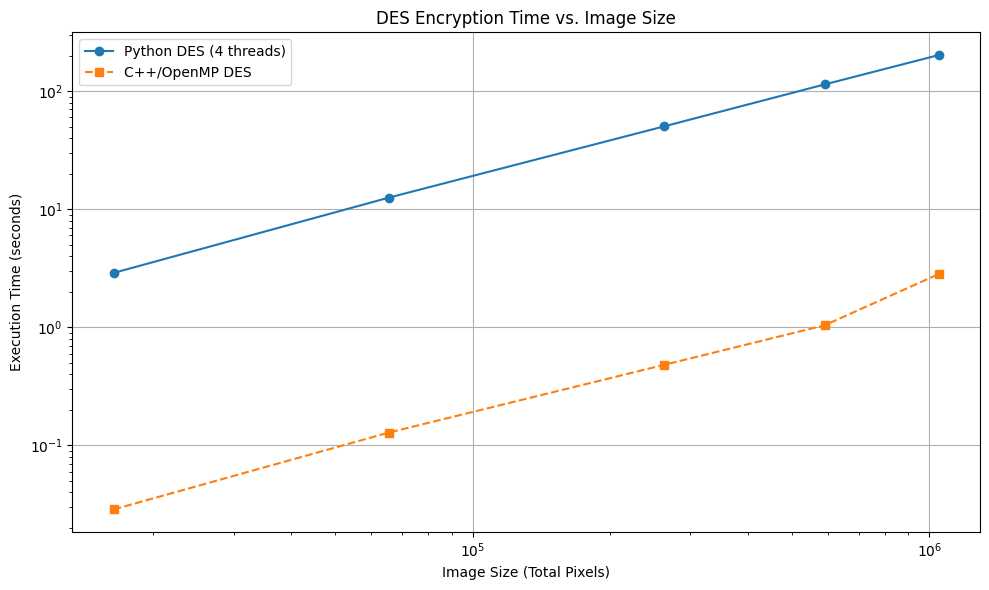


--- Raw Results ---
{'size_pixels': [16384, 65536, 262144, 589824, 1048576], 'python_time': [2.8920819759368896, 12.54097867012024, 50.26146388053894, 114.10492730140686, 202.36903882026672], 'cpp_time': [0.0287085, 0.128356, 0.480377, 1.04065, 2.82797]}
-------------------


In [18]:
import os
import time
import numpy as np
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
# If you specifically need AVIF support and installed pillow_avif:
# import pillow_avif
import subprocess
import matplotlib.pyplot as plt
import re # For parsing C++ output

# --- STEP 1: Include your Python DES Implementation ---
# (Copied from your original code provided earlier)

DES_BLOCK_SIZE = 8

IP = [58, 50, 42, 34, 26, 18, 10, 2,
      60, 52, 44, 36, 28, 20, 12, 4,
      62, 54, 46, 38, 30, 22, 14, 6,
      64, 56, 48, 40, 32, 24, 16, 8,
      57, 49, 41, 33, 25, 17, 9, 1,
      59, 51, 43, 35, 27, 19, 11, 3,
      61, 53, 45, 37, 29, 21, 13, 5,
      63, 55, 47, 39, 31, 23, 15, 7]

IP_INV = [40, 8, 48, 16, 56, 24, 64, 32,
          39, 7, 47, 15, 55, 23, 63, 31,
          38, 6, 46, 14, 54, 22, 62, 30,
          37, 5, 45, 13, 53, 21, 61, 29,
          36, 4, 44, 12, 52, 20, 60, 28,
          35, 3, 43, 11, 51, 19, 59, 27,
          34, 2, 42, 10, 50, 18, 58, 26,
          33, 1, 41, 9, 49, 17, 57, 25]

class DESImageEncryptor:
    def __init__(self, key):
        self.key = self._validate_key(key)
        self.subkeys = self._generate_subkeys()

    def _validate_key(self, key):
        if not isinstance(key, bytes):
            raise ValueError("Key must be 8 bytes")
        if len(key) != 8:
            raise ValueError("Key must be exactly 8 bytes long")
        return key

    def _generate_subkeys(self):
        subkeys = []
        key_bits = self._bytes_to_bits(self.key)
        pc1 = [57, 49, 41, 33, 25, 17, 9, 1,
               58, 50, 42, 34, 26, 18, 10, 2,
               59, 51, 43, 35, 27, 19, 11, 3,
               60, 52, 44, 36, 63, 55, 47, 39,
               31, 23, 15, 7, 62, 54, 46, 38,
               30, 22, 14, 6, 61, 53, 45, 37,
               29, 21, 13, 5, 28, 20, 12, 4]
        permuted_key = ''.join(key_bits[pc1[i]-1] for i in range(56))
        left, right = permuted_key[:28], permuted_key[28:]
        rotations = [1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1]
        pc2 = [14, 17, 11, 24, 1, 5, 3, 28,
               15, 6, 21, 10, 23, 19, 12, 4,
               26, 8, 16, 7, 27, 20, 13, 2,
               41, 52, 31, 37, 47, 55, 30, 40,
               51, 45, 33, 48, 44, 49, 39, 56,
               34, 53, 46, 42, 50, 36, 29, 32]
        for rotation in rotations:
            left = left[rotation:] + left[:rotation]
            right = right[rotation:] + right[:rotation]
            combined = left + right
            subkey = ''.join(combined[pc2[i]-1] for i in range(48))
            subkeys.append(self._bits_to_bytes(subkey))
        return subkeys

    def _bytes_to_bits(self, byte_data):
        return ''.join(format(byte, '08b') for byte in byte_data)

    def _bits_to_bytes(self, bit_string):
        # Ensure bit_string length is a multiple of 8
        padded_len = (len(bit_string) + 7) // 8 * 8
        bit_string = bit_string.ljust(padded_len, '0')
        return bytes(int(bit_string[i:i+8], 2) for i in range(0, len(bit_string), 8))

    def _feistel_function(self, right_half, subkey):
        expansion = [32, 1, 2, 3, 4, 5, 4, 5, 6, 7, 8, 9,
                     8, 9, 10, 11, 12, 13, 12, 13, 14, 15, 16, 17,
                     16, 17, 18, 19, 20, 21, 20, 21, 22, 23, 24, 25,
                     24, 25, 26, 27, 28, 29, 28, 29, 30, 31, 32, 1]
        right_bits = self._bytes_to_bits(right_half)
         # Pad right_bits if necessary (should be 32 bits -> 4 bytes)
        if len(right_bits) < 32:
            right_bits = right_bits.ljust(32, '0')
        expanded_bits = ''.join(right_bits[expansion[i]-1] for i in range(48))
        subkey_bits = self._bytes_to_bits(subkey)
        # Pad subkey_bits if necessary (should be 48 bits -> 6 bytes)
        if len(subkey_bits) < 48:
             subkey_bits = subkey_bits.ljust(48, '0')

        xored_bits = ''.join('0' if a == b else '1' for a, b in zip(expanded_bits, subkey_bits))
        substituted_bits = self._s_box_substitution(xored_bits) # Uses simplified S-Box from original code
        p_box = [16, 7, 20, 21, 29, 12, 28, 17,
                 1, 15, 23, 26, 5, 18, 31, 10,
                 2, 8, 24, 14, 32, 27, 3, 9,
                 19, 13, 30, 6, 22, 11, 4, 25]

        # Pad substituted_bits if needed (should be 32 bits)
        if len(substituted_bits) < 32:
            substituted_bits = substituted_bits.ljust(32, '0')
        permuted_bits = ''.join(substituted_bits[p_box[i]-1] for i in range(32))
        return self._bits_to_bytes(permuted_bits)

    def _s_box_substitution(self, bits):
         # This is the *simplified/incorrect* S-box function from the original Python code
         # Ensure length is multiple of 6 for the loop
        padded_len = (len(bits) + 5) // 6 * 6
        bits = bits.ljust(padded_len, '0')
        output_bits = ""
        for i in range(0, len(bits), 6):
             chunk = bits[i:i+6]
             val = int(chunk, 2)
             # The original modulo logic - this is NOT standard DES S-Box behaviour
             s_val = val % 16 # Simplified example, original used mod 64 then format 6b? Let's stick to the logic visible
             output_bits += format(s_val, '04b') # Output 4 bits per 6 bits input like real S-Boxes
        # Pad output to 32 bits if needed
        return output_bits.ljust(32, '0')


    def encrypt_block(self, block):
        if len(block) != 8:
            # Pad the block if it's not 8 bytes - crucial for last block
            block = block.ljust(8, b'\x00') # Simple zero padding for raw block

        block_bits = self._bytes_to_bits(block)
        ip_bits = ''.join(block_bits[IP[i]-1] for i in range(64))
        left, right = ip_bits[:32], ip_bits[32:]

        for i in range(16):
            old_right_bytes = self._bits_to_bytes(right) # Convert current right to bytes for Feistel
            f_output = self._feistel_function(old_right_bytes, self.subkeys[i])
            f_bits = self._bytes_to_bits(f_output).ljust(32, '0') # Ensure 32 bits

            new_right_bits = ''.join('1' if l_bit != f_bit else '0' for l_bit, f_bit in zip(left, f_bits))
            left = right # Old right becomes new left
            right = new_right_bits # Calculated new right

        combined = right + left # Swapped L/R at the end
        final_bits = ''.join(combined[IP_INV[i]-1] for i in range(64))
        return self._bits_to_bytes(final_bits)

# Using the existing parallel function for consistency, though timing includes overhead
def parallel_encrypt_image_python(img, key, num_threads=4):
    img_array = np.array(img)
    flat_data = img_array.tobytes()

    pad_len = DES_BLOCK_SIZE - (len(flat_data) % DES_BLOCK_SIZE)
    if pad_len == 0:
        pad_len = DES_BLOCK_SIZE
    padded_data = flat_data + bytes([pad_len] * pad_len)

    encryptor = DESImageEncryptor(key)
    encrypted_data_list = []

    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = [
            executor.submit(encryptor.encrypt_block, padded_data[i:i+DES_BLOCK_SIZE])
            for i in range(0, len(padded_data), DES_BLOCK_SIZE)
        ]
        for future in futures:
            encrypted_data_list.append(future.result())

    encrypted_data = b''.join(encrypted_data_list)
    return encrypted_data

# --- End of Python DES Implementation ---


# --- STEP 2: Benchmarking Setup ---

# Check if the C++ executable exists
cpp_executable = "./des_image_processor"
if not os.path.exists(cpp_executable):
    print(f"ERROR: C++ executable '{cpp_executable}' not found.")
    print("Please ensure you have run Cell 3 successfully to compile the C++ code.")
    exit()
if not os.access(cpp_executable, os.X_OK):
    print(f"ERROR: C++ executable '{cpp_executable}' is not executable.")
    print("Try running: chmod +x {cpp_executable}")
    exit()

# Define image sizes (width, height) to test
# Using smaller sizes initially for quicker testing
image_dimensions = [
    (128, 128),
    (256, 256),
    (512, 512),
    (768, 768),
    (1024, 1024),
    # Add more sizes as needed
    # (1536, 1536),
    # (2048, 2048),
]

# Store results
results = {
    'size_pixels': [],
    'python_time': [],
    'cpp_time': []
}

# Temporary file names
temp_image_file = "temp_benchmark_image.png"
temp_encrypted_file = "temp_benchmark_encrypted.png" # C++ code creates this

# Number of threads for Python parallel execution (adjust if needed)
NUM_PYTHON_THREADS = 4


# --- STEP 3: Benchmarking Loop ---

print("Starting benchmark...")

for width, height in image_dimensions:
    print(f"\n--- Testing image size: {width}x{height} ---")
    num_pixels = width * height
    results['size_pixels'].append(num_pixels)

    # 1. Generate synthetic image
    try:
        print("Generating image...")
        # Create a random RGB image
        random_image_data = np.random.randint(0, 256, (height, width, 3), dtype=np.uint8)
        img = Image.fromarray(random_image_data, 'RGB')
        img.save(temp_image_file, "PNG")
        print(f"Image '{temp_image_file}' saved.")
    except Exception as e:
        print(f"Error generating/saving image: {e}")
        results['python_time'].append(None) # Mark as failed
        results['cpp_time'].append(None)    # Mark as failed
        continue # Skip to next size

    # 2. Time Python Encryption
    try:
        print("Timing Python DES encryption...")
        key_py = os.urandom(8) # Generate a random key for this run
        img_py = Image.open(temp_image_file).convert('RGB') # Reload image

        start_time_py = time.time()
        # Using the modified parallel encrypt function focusing on crypto ops
        _ = parallel_encrypt_image_python(img_py, key_py, num_threads=NUM_PYTHON_THREADS)
        end_time_py = time.time()

        duration_py = end_time_py - start_time_py
        results['python_time'].append(duration_py)
        print(f"Python time: {duration_py:.4f} seconds")
    except Exception as e:
        print(f"Error during Python encryption: {e}")
        results['python_time'].append(None) # Mark as failed

    # 3. Time C++/OpenMP Encryption
    try:
        print("Timing C++/OpenMP DES encryption...")
        # Command to execute C++ encryption
        # It generates its own key internally when encrypting
        command = [
            cpp_executable,
            "encrypt",
            temp_image_file,
            temp_encrypted_file # Output file for C++ code
        ]

        # Run the C++ executable and capture output
        process_result = subprocess.run(
            command,
            capture_output=True,
            text=True,
            check=False # Don't throw exception on non-zero exit code immediately
        )

        # Check for errors during C++ execution
        if process_result.returncode != 0:
            print(f"Error running C++ code (return code {process_result.returncode}):")
            print("--- C++ stdout ---")
            print(process_result.stdout)
            print("--- C++ stderr ---")
            print(process_result.stderr)
            print("--------------------")
            results['cpp_time'].append(None) # Mark as failed
        else:
            # Parse the output to find the execution time
            cpp_output = process_result.stdout
            # Regex to find "Encryption finished in X.XXXX seconds."
            match = re.search(r"Encryption finished in (\d+\.?\d*) seconds", cpp_output)
            if match:
                duration_cpp = float(match.group(1))
                results['cpp_time'].append(duration_cpp)
                print(f"C++/OpenMP time: {duration_cpp:.4f} seconds")
                # Print the key C++ used (optional)
                key_match = re.search(r"Generating random 8-byte key \(HEX\): ([0-9a-fA-F]{16})", cpp_output)
                if key_match:
                    print(f"C++ used key: {key_match.group(1)}")
            else:
                print("Error: Could not parse execution time from C++ output.")
                print("--- C++ stdout ---")
                print(process_result.stdout)
                print("--------------------")
                results['cpp_time'].append(None) # Mark as failed

    except Exception as e:
        print(f"Error running/parsing C++ encryption: {e}")
        results['cpp_time'].append(None) # Mark as failed

    # 4. Clean up temporary files
    try:
        if os.path.exists(temp_image_file):
            os.remove(temp_image_file)
        if os.path.exists(temp_encrypted_file):
            os.remove(temp_encrypted_file)
        # print("Temporary files cleaned up.")
    except Exception as e:
        print(f"Warning: Could not clean up temporary files: {e}")

print("\nBenchmark finished.")


# --- STEP 4: Plotting Results ---

print("Plotting results...")

# Filter out None values in case of errors
valid_indices = [i for i, (pt, ct) in enumerate(zip(results['python_time'], results['cpp_time'])) if pt is not None and ct is not None]

if not valid_indices:
    print("No valid results to plot. Please check for errors during benchmarking.")
else:
    plot_sizes = [results['size_pixels'][i] for i in valid_indices]
    plot_python_times = [results['python_time'][i] for i in valid_indices]
    plot_cpp_times = [results['cpp_time'][i] for i in valid_indices]

    plt.figure(figsize=(10, 6))
    plt.plot(plot_sizes, plot_python_times, marker='o', linestyle='-', label=f'Python DES ({NUM_PYTHON_THREADS} threads)')
    plt.plot(plot_sizes, plot_cpp_times, marker='s', linestyle='--', label='C++/OpenMP DES')

    plt.title('DES Encryption Time vs. Image Size')
    plt.xlabel('Image Size (Total Pixels)')
    plt.ylabel('Execution Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')
    plt.yscale('log')

    plt.tight_layout()
    plt.show()

print("\n--- Raw Results ---")
print(results)
print("-------------------")